In [1]:
# Importando as bibliotecas e módulos
import pandas as pd
import numpy as np
from asd import dataset, utilits, metrics
from sklearn.model_selection import train_test_split, KFold, StratifiedKFold 
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
import sklearn.metrics

In [2]:
# Criando dataframe
df = dataset.autism()
# Tratamento dos dados
X,Y = dataset.basicResourceEngineering(df)

In [3]:
# Variáveis Independentes
X.head()

,A1_Score,A2_Score,A3_Score,A4_Score,A5_Score,A6_Score,A7_Score,A8_Score,A9_Score,A10_Score
0,1,1,0,0,1,1,0,1,0,0
1,1,1,0,0,1,1,0,1,0,0
2,1,1,0,0,0,1,1,1,0,0
3,0,1,0,0,1,1,0,0,0,1
4,1,1,1,1,1,1,1,1,1,1


In [4]:
# Variável Dependente
Y.head()

0    Sem_Autismo
1    Sem_Autismo
2    Sem_Autismo
3    Sem_Autismo
4        Autismo
Name: Class/ASD, dtype: object

# KNN - K Nearest Neighbors

**Funcionamento:** O KNN é um algoritmo supervisionado que pode ser construído tanto para Classificação quanto para Regressão. Seu funcionamento é bem simples:

**1.** Calcula-se a distância entre a nova observação e as demais;

**2.** Ordena-se todas as distâncias de forma Crescente ou Decrescente, dependendo da aplicação;

**3.** Retorna as K melhores observações que tiveram as melhores distâncias.


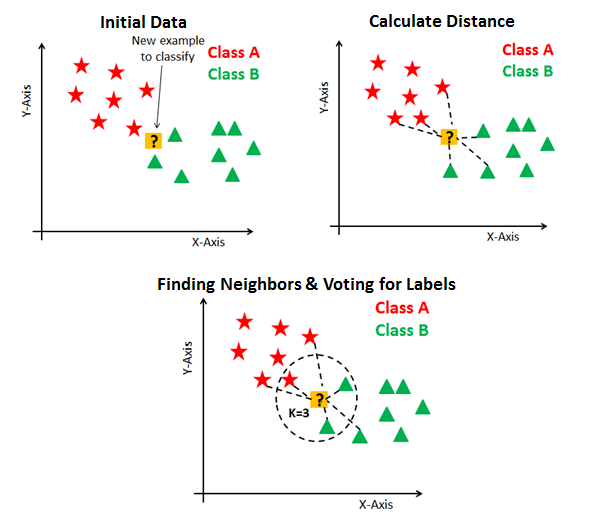

In [5]:
# Modelo
knn = KNeighborsClassifier()
knn

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
                     metric_params=None, n_jobs=None, n_neighbors=5, p=2,
                     weights='uniform')

In [16]:
# Seleção do Melhor K e melhor Distância
# A formulado cálculo da distância é Minkowski, ou seja:

# P = 2 -> Cálculo da distância Euclidiana
# P = 1 - > Calculo da distância de Manhatan

kGroup = [1,2,3,4,5,6,7,8,9,10]
pGroup = [1,2,3,4]

In [17]:
# Validação cruzada
def crossValidation(knn,X,Y,splits):
    metricas = []
    i = 0
    skf = StratifiedKFold(n_splits = splits, shuffle = True, random_state = 1)
    # Separando as bases de treino e teste
    for train,test in skf.split(X,Y):
        # Dicionaro de treino
        train_x, test_x = X.iloc[train], X.iloc[test]
        train_y, test_y = Y.iloc[train], Y.iloc[test]
        aux = knn.fit(train_x,train_y)
        rst = aux.predict(test_x)
        metricas.append(metrics.classification_report(test_y, rst))
        i+=1
    return metricas

In [19]:
optimizerParams = {'k':[],'p':[],'accuracy':[],'precision':[],'recall':[],'f1':[]}
splits = 5
# Otimização de parâmetros
for k in kGroup:
    for p in pGroup:
        knn = KNeighborsClassifier(n_neighbors = k, p = p)
        metricas = crossValidation(knn,X,Y,splits)
        optimizerParams['k'].append(k)
        optimizerParams['p'].append(p)
        optimizerParams['accuracy'].append(np.mean(np.array([metricas[x]['accuracy'] for x in range(5)])))
        optimizerParams['precision'].append(np.mean(np.array([metricas[x]['precision'] for x in range(5)])))
        optimizerParams['recall'].append(np.mean(np.array([metricas[x]['recall'] for x in range(5)])))
        optimizerParams['f1'].append(np.mean(np.array([metricas[x]['f1'] for x in range(5)])))
        
Optimizer = pd.DataFrame.from_dict(optimizerParams)

In [20]:
Optimizer

,k,p,accuracy,precision,recall,f1
0,1,1,0.847269,0.924241,0.943103,0.933409
1,1,2,0.847269,0.924241,0.943103,0.933409
2,1,3,0.847269,0.924241,0.943103,0.933409
3,1,4,0.847269,0.924241,0.943103,0.933409
4,2,1,0.913164,0.826851,0.978818,0.896078
5,2,2,0.913164,0.826851,0.978818,0.896078
6,2,3,0.913164,0.826851,0.978818,0.896078
7,2,4,0.913164,0.826851,0.978818,0.896078
8,3,1,0.852622,0.899402,0.943350,0.919938
9,3,2,0.852622,0.899402,0.943350,0.919938
